# Machine Learning - Predict Good Quality White Vinho Verde

In this notebook a machine learning model to predict the quality of white vinho verde wines is implemented and evaluated. 

The goal is to predict if a wine is high quality or not

# Import Packages and Functions

In [ ]:
import pandas as pd
# import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

from xgboost import XGBClassifier

import sklearn
from sklearn.preprocessing import (
    OrdinalEncoder, LabelEncoder, 
    MinMaxScaler, RobustScaler, StandardScaler,
    FunctionTransformer,
    PolynomialFeatures
    )
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.impute import SimpleImputer
# from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline as SklPipeline
from sklearn.metrics import (
    make_scorer,
    accuracy_score, precision_score, recall_score, f1_score, 
    precision_recall_fscore_support,
    classification_report, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
)
from sklearn.inspection import permutation_importance

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

import shap

# from skopt import BayesSearchCV

# TODO checkout this pipeline library 
# from neuraxle.pipeline import Pipeline

In [337]:
%run ../src/constants.py

# Import and Pre-clean Data

In [338]:
# import white wine
wine = pd.read_parquet('../data/processed/wine_w.parquet')

In [339]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3961 entries, 0 to 4897
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   ph                                   3961 non-null   float64 
 1   fixed_acidity                        3961 non-null   float64 
 2   volatile_acidity                     3961 non-null   float64 
 3   citric_acid                          3961 non-null   float64 
 4   chlorides                            3961 non-null   float64 
 5   total_sulfur_dioxide                 3961 non-null   float64 
 6   free_sulfur_dioxide                  3961 non-null   float64 
 7   sulphates                            3961 non-null   float64 
 8   residual_sugar                       3961 non-null   float64 
 9   density                              3961 non-null   float64 
 10  alcohol                              3961 non-null   float64 
 11  quality               

## Config

In [520]:
remove_outliers = True
DO_SHAP_EXPLAINER = True
DO_CROSS_VAL = False
DO_GRIDSEARCH_RF = True
DO_GRIDSEARCH_SVC = True

features_removed = [
    'color',
    # 'fixed_acidity', 'volatile_acidity', 'citric_acid',
    'total_acidity',
    # 'total_sulfur_dioxide', 
    # 'free_sulfur_dioxide',
    # 'sulphates',
    # 'residual_sugar',
    # 'ph',
    # 'density',
    'acidity_ratio',
    'sulfur_dioxide_ratio',
    'total_sulfur_dioxide_above_eu_limit', 
    'volatile_acid_above_eu_limit'
    ]

target, target_alt = 'quality_label', 'quality'
# target, target_alt = target_alt, target
features_removed.append(target_alt)

## Remove outliers

Remove low quality outlier wines!

In [341]:
MIN_Q_RATING = 7

if remove_outliers:
    outlier_mask = ((wine.input_outlier_count>=1) | wine.input_outliers_if) & (wine.quality<=MIN_Q_RATING)
    # outlier_mask = ((wine.input_outlier_count>=1)) & (wine.quality<=MIN_Q_RATING)
    wine = wine[~outlier_mask]
wine = wine.drop(columns=['input_outlier_count', 'input_outliers_if'])
wine.shape

(3331, 19)

In [342]:
if outlier_mask is not None:
    print(sum(outlier_mask))

630


## Remove Features

In [343]:
wine = wine.drop(columns=features_removed)

features = [input for input in wine.columns if (input not in features_removed) and (input != target) and (input != target)]
print('selected features are:')
features

selected features are:


['ph',
 'fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'chlorides',
 'total_sulfur_dioxide',
 'free_sulfur_dioxide',
 'sulphates',
 'residual_sugar',
 'density',
 'alcohol']

## Analyse Input Data

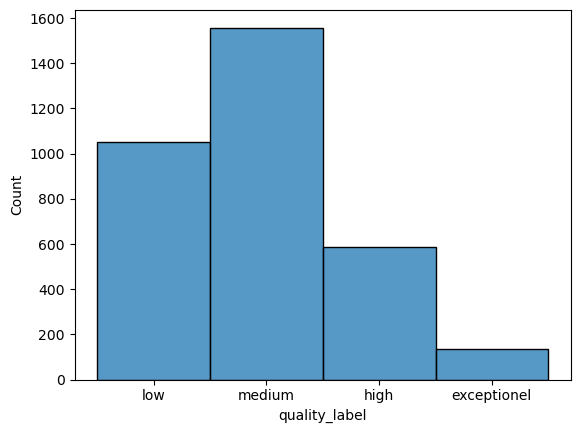

In [344]:
if 'quality_label' in wine.columns:
    sns.histplot(wine, x='quality_label', discrete=True);
else:
    sns.histplot(wine, x='quality', discrete=True);

# Transform Target

In [345]:
# encode quality label
if 'quality_label' in wine.columns:
    # TODO is there another way to ensure order? seems kind of sloppy
    categories_in_order = list(wine.quality_label.value_counts().sort_index().index) # such that number of labels can be changed 
    oe = OrdinalEncoder(categories=[categories_in_order]) # NOTE give the order in here; has to be an array of n features 
    wine['quality_label'] = oe.fit_transform(pd.DataFrame(wine['quality_label'])) # NOTE conversion to dataframe needed here, because that bastard requires a (n_samples, n_features) shape
    qlabels = sorted(wine.quality_label.unique()) #[0.0, 2.0, 3.0]

# Split Data Set

In [346]:
# Split the data into training and testing sets
# TODO move configuration to config file?
TEST_SIZE = 0.20
RANDOM_STATE = 42

X = wine[features]
if 'quality_label' in wine.columns:
    y = wine.quality_label
else:
    y = wine.quality

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

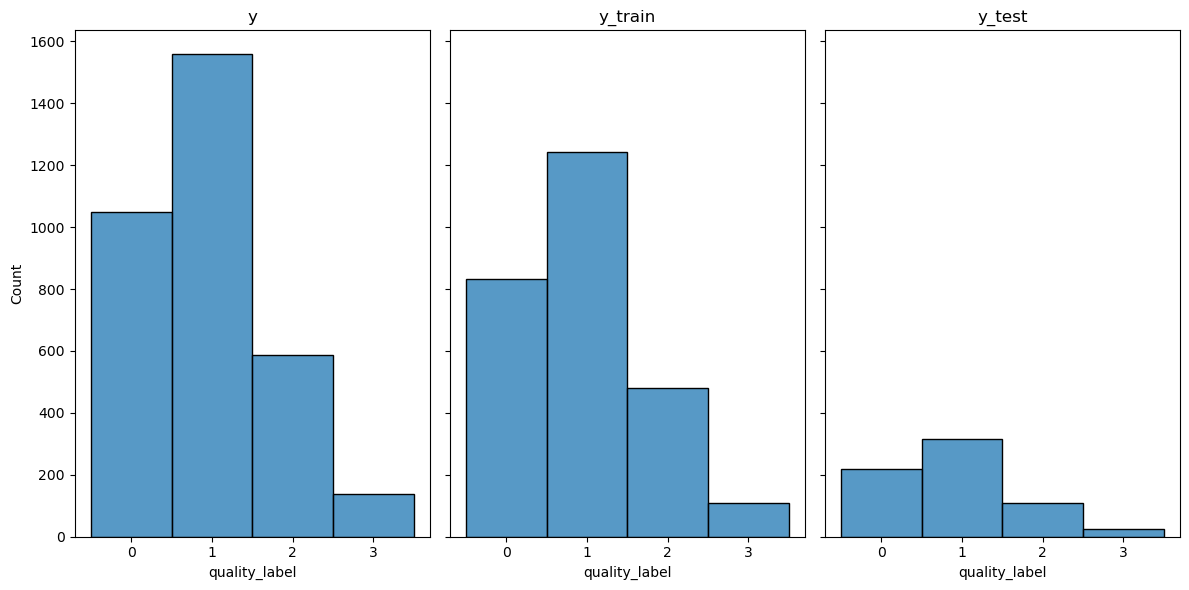

In [347]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)

sns.histplot(y, discrete=True, ax=ax[0])
sns.histplot(y_train, discrete=True, ax=ax[1])
sns.histplot(y_test, discrete=True, ax=ax[2])

ax[0].set_title('y')
ax[1].set_title('y_train')
ax[2].set_title('y_test')

plt.tight_layout()

In [348]:
quality_label_vcounts = y_train.value_counts()
quality_label_vcounts

quality_label
1.0    1243
0.0     832
2.0     479
3.0     110
Name: count, dtype: int64

# Machine Learning

In [ ]:
# configure sampling

def calc_undersampling_startegy(y):
    '''
    calculate undersampling strategy for wine quality label
      - undersample majority class to 80%
      - undersample other classes to minority class
      - keep minority class
    '''
    UNDERSAMPLING_FAC_MAJ_CLASS=0.8
    # quality_label_vcounts = y.value_counts()
    unique, counts = np.unique(y, return_counts=True)
    quality_label_vcounts = dict(zip(unique,counts))
    return {
        0: quality_label_vcounts[2], #min(quality_label_vcounts[0], quality_label_vcounts[2]),
        1: int(np.floor(UNDERSAMPLING_FAC_MAJ_CLASS*quality_label_vcounts[1])),
        2: quality_label_vcounts[2],
        3: quality_label_vcounts[3]
        }

undersampling_strategy = calc_undersampling_startegy
# undersampling_strategy = 'auto'
oversampling_strategy = 'auto'

In [472]:
# Build Pipeline

# log scale features with high skew
features_to_log_scale = ['volatile_acidity', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide']
features_remaining = [f for f in features if f not in features_to_log_scale]

# Create log preprocessor
preprocessor_log = ColumnTransformer(
    transformers=[
        ('log', FunctionTransformer(np.log1p), features_to_log_scale),
        ('passthrough_remaining', 'passthrough', features_remaining)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)
# preprocessor_log.set_params(verbose_feature_names_out=False)


Pipeline(steps=[('scale', RobustScaler()),
                ('interactions',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('drop_cols',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('column_dropper', 'drop',
                                                  array(['chlorides density', 'chlorides free_sulfur_dioxide',
       'chlorides residual_sugar', 'chlorides sulphates',
       'chlorides total_sulfur_dioxide', '...
       'volatile_acidity residual_sugar', 'volatile_acidity sulphates',
       'volatile_acidity total_sulfur_dioxide'], dtype='<U40'))])),
                ('undersampling',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy=<function calc_undersampling_startegy at 0x0000016999103380>)),
                ('oversampling', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

In [ ]:

# dropping interactions
columns_to_drop = ['volatile_acidity chlorides', 'free_sulfur_dioxide residual_sugar', 'total_sulfur_dioxide residual_sugar',
                   'citric_acid total_sulfur_dioxide', 'volatile_acidity total_sulfur_dioxide', 'total_sulfur_dioxide free_sulfur_dioxide']
                   
columns_to_drop.extend(['sulphates density', 'fixed_acidity residual_sugar',
       'citric_acid residual_sugar', 'fixed_acidity alcohol',
       'volatile_acidity residual_sugar', 'fixed_acidity sulphates',
       'fixed_acidity chlorides', 'ph chlorides',
       'citric_acid sulphates', 'chlorides residual_sugar',
       'ph free_sulfur_dioxide', 'citric_acid chlorides',
       'ph total_sulfur_dioxide', 'total_sulfur_dioxide sulphates',
       'chlorides free_sulfur_dioxide', 'citric_acid density',
       'fixed_acidity density', 'volatile_acidity citric_acid',
       'volatile_acidity free_sulfur_dioxide', 'chlorides sulphates'])

columns_to_drop.extend(['ph volatile_acidity',
       'chlorides density', 'chlorides total_sulfur_dioxide',
       'fixed_acidity total_sulfur_dioxide',
       'total_sulfur_dioxide density', 'free_sulfur_dioxide sulphates',
       'fixed_acidity citric_acid', 'sulphates residual_sugar',
       'citric_acid alcohol', 'citric_acid free_sulfur_dioxide',
       'ph citric_acid', 'fixed_acidity volatile_acidity',
       'free_sulfur_dioxide alcohol', 'volatile_acidity sulphates'])

columns_to_drop = np.unique(columns_to_drop)

preprocessor_drop = ColumnTransformer(
    transformers=[
        ('column_dropper', 'drop', columns_to_drop)
    ],
    remainder='passthrough'
)


## Random Forest Classifier

In [ ]:

pipe = Pipeline(steps=[
    # ('preprocessor_log', preprocessor_log), # does not make a big difference
    ('scale', RobustScaler()),
    ('interactions', PolynomialFeatures(interaction_only=True, include_bias=False)),
    # ('pca', PCA(n_components=20)),
    ('drop_cols', preprocessor_drop),
    ('undersampling', RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=RANDOM_STATE)),
    ('oversampling', SMOTE(sampling_strategy=oversampling_strategy, random_state=RANDOM_STATE)),
    # ('combinedsampling', SMOTEENN(sampling_strategy=oversampling_strategy, random_state=RANDOM_STATE)),
    ("classifier", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
    ])

pipe.set_output(transform='pandas')

pipe

In [ ]:
# Hyperparameter tuning for RandomForestClassifier

# best params form previous runs
best_params_rf = {'classifier__criterion': 'gini', 
                  'classifier__max_depth': None, 
                  'classifier__min_samples_leaf': 1, 
                  'classifier__min_samples_split': 3, 
                  'classifier__n_estimators': 200
                  }

if DO_GRIDSEARCH_RF:
    param_grid_rf = {
        'classifier__n_estimators': [100, 200, 500], # 1000
        'classifier__max_depth': [None, 1000], # None
        'classifier__min_samples_split': [2, 3, 5], # 2
        'classifier__min_samples_leaf': [1, 3, 5], # 1
        'classifier__criterion': ['gini']
    }

    # scorer = make_scorer(accuracy_score)
    # scorer = make_scorer(lambda y_test, y_pred: f1_score(y_test, y_pred, average='weighted'))
    scorer = make_scorer(lambda y_true, y_pred: recall_score(y_test, y_pred, average='weighted'))

    cv = StratifiedKFold(n_splits=3)

    grid_search_rf = GridSearchCV(pipe, param_grid_rf, cv=cv, scoring=scorer)

    grid_search_rf.fit(X_train, y_train)

    if best_params_rf:
        best_params_rf_prev = best_params_rf
        best_score_rf_prev = best_score_rf
        print("Previous best parameters:", best_params_rf_prev)
        print("Previous best score:", best_score_rf_prev)
         
    # Get the best parameters and the best score
    best_params_rf = grid_search_rf.best_params_
    best_score_rf = grid_search_rf.best_score_

    print("Best parameters:", best_params_rf)
    print("Best score:", best_score_rf)

TypeError: unhashable type: 'dict'

In [479]:
# predict
pipe[-1].set_params(**{key.replace('classifier__',''): val for key,val in best_params_rf.items()})
pipe[-1].set_params(oob_score=True)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

## SVC

In [ ]:
# Build Pipeline SVC
pipe_svc = Pipeline(steps=[
    ("scaler", RobustScaler()),
    ('interactions', PolynomialFeatures(interaction_only=True, include_bias=False)),
    ('drop_cols', preprocessor_drop),
    ('undersampling', RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=RANDOM_STATE)),
    ('oversampling', SMOTE(sampling_strategy=oversampling_strategy, random_state=RANDOM_STATE)),
    ('classifier', SVC(random_state=RANDOM_STATE))
    ])

pipe_svc.set_output(transform='pandas')

pipe_svc

Pipeline(steps=[('scaler', RobustScaler()),
                ('interactions',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('drop_cols',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('column_dropper', 'drop',
                                                  array(['chlorides density', 'chlorides free_sulfur_dioxide',
       'chlorides residual_sugar', 'chlorides sulphates',
       'chlorides total_sulfur_dioxide',...
       'volatile_acidity free_sulfur_dioxide',
       'volatile_acidity residual_sugar', 'volatile_acidity sulphates',
       'volatile_acidity total_sulfur_dioxide'], dtype='<U40'))])),
                ('undersampling',
                 RandomUnderSampler(random_state=42,
                                    sampling_strategy=<function calc_undersampling_startegy at 0x0000016999103380>)),
                ('oversampling', SMOTE(random_state=42)),
                ('classifier', SVC(random_state=42))])

In [523]:
# Hyperparameter tuning
best_params_svc = {
    'classifier__C': 5.0, 
    'classifier__degree': 3, 
    'classifier__gamma': 'scale', 
    'classifier__kernel': 'rbf', 
    'classifier__max_iter': 5000
    }

if DO_GRIDSEARCH_SVC:
    # Define the parameter grid
    param_grid_svc = {
        'classifier__C': [5.0, 10, 20],
        'classifier__max_iter': [1000, 5000],
        'classifier__degree': [3],
        'classifier__gamma': ['scale'],
        'classifier__kernel': ['rbf'],
    }

    # Create a scorer object from your custom function
    # scorer = make_scorer(f1_score_class_high)
    # scorer = make_scorer(accuracy_score)
    scorer = make_scorer(lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'))
    scorer = make_scorer(lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'))

    cv = StratifiedKFold(n_splits=5)

    grid_search_svc = GridSearchCV(pipe_svc, param_grid_svc, cv=cv, scoring=scorer)

    # Fit GridSearchCV to the training data
    grid_search_svc.fit(X_train, y_train)

    # Get the best parameters and the best score
    best_params_svc = grid_search_svc.best_params_
    best_score_svc = grid_search_svc.best_score_

    print("Best parameters for RandomForestClassifier:", best_params_svc)
    print("Best score:", best_score_svc)

c:\Users\olive\anaconda3\envs\base_data_analysis\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\olive\anaconda3\envs\base_data_analysis\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\olive\anaconda3\envs\base_data_analysis\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\olive\anaconda3\envs\base_data_analysis\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\olive\anaconda3\env

Best parameters for RandomForestClassifier: {'classifier__C': 10, 'classifier__degree': 3, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'classifier__max_iter': 1000}
Best score: 0.4897080593916203


c:\Users\olive\anaconda3\envs\base_data_analysis\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [524]:
pipe_svc[-1].set_params(**{key.replace('classifier__',''): val for key,val in best_params_svc.items()})
pipe_svc.fit(X_train, y_train)
y_pred_svc = pipe_svc.predict(X_test)

c:\Users\olive\anaconda3\envs\base_data_analysis\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


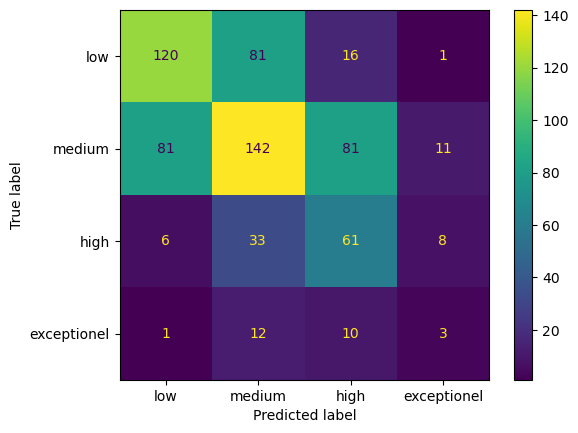

In [525]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_svc)
if target == 'quality_label':
    ConfusionMatrixDisplay(cm, display_labels=categories_in_order).plot()
else:
    ConfusionMatrixDisplay(cm, display_labels=[3,4,5,6,7,8]).plot()

In [526]:
print(classification_report(y_test, y_pred_svc, digits=3))

              precision    recall  f1-score   support

         0.0      0.577     0.550     0.563       218
         1.0      0.530     0.451     0.487       315
         2.0      0.363     0.565     0.442       108
         3.0      0.130     0.115     0.122        26

    accuracy                          0.489       667
   macro avg      0.400     0.420     0.404       667
weighted avg      0.503     0.489     0.491       667



SVC could not reach the same scoring as random forest

# Evaluate

## Baseline

In [480]:
# fraction of high quality labeled wines
probs_quality_label = wine.quality_label.value_counts() / wine.quality_label.sum()
prob_high_quality = probs_quality_label[2]+probs_quality_label[3]
print(f'Baseline probability that a produced wine might be high quality is {prob_high_quality:.2%}')
print(f'Baseline accuracy therefore is () {1-prob_high_quality:.2%}')

Baseline probability that a produced wine might be high quality is 23.03%
Baseline accuracy therefore is () 76.97%


## Model evaluation

In [ ]:
pd.DataFrame()

Training Score      0.897147
OOB Score           0.800050
Validation Score    0.547226
dtype: float64


<Axes: >

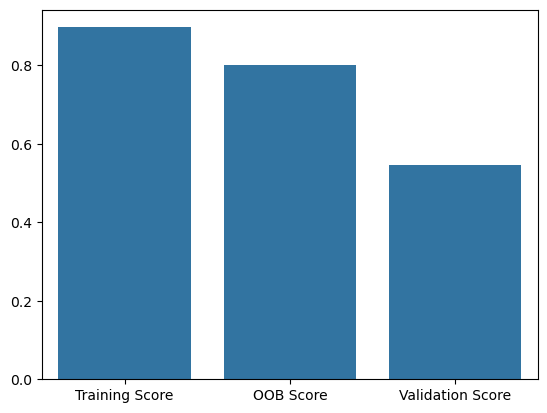

In [536]:
scores_overfitting = pd.Series({
    'Training Score':pipe.score(X_train, y_train), 
    'OOB Score':pipe[-1].oob_score_, 
    'Validation Score':pipe.score(X_test, y_test)}
    )
print(scores_overfitting)

sns.barplot(scores_overfitting)

Overfitting might be present:
- Trainings and validation score are widely different.
- However, OOB score is quite high, meaning it performs ok on unseen data, and it is quite close to the Training Score. 

In [537]:
# accuracy score
# pipe.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.5472263868065967

In [483]:
precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred, labels=qlabels)
for qlabel, f1 in zip(qlabels, f1score):
    print('f1score', qlabel, '\t', f1)

f1score 0.0 	 0.5894206549118388
f1score 1.0 	 0.5709677419354838
f1score 2.0 	 0.4827586206896552
f1score 3.0 	 0.2857142857142857


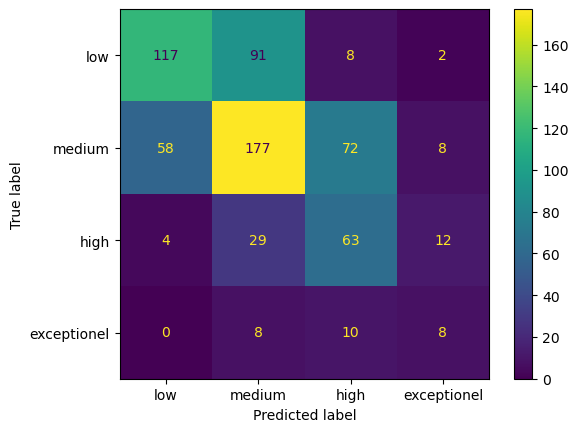

In [538]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
if target == 'quality_label':
    ConfusionMatrixDisplay(cm, display_labels=categories_in_order).plot()
else:
    ConfusionMatrixDisplay(cm, display_labels=[3,4,5,6,7,8]).plot()

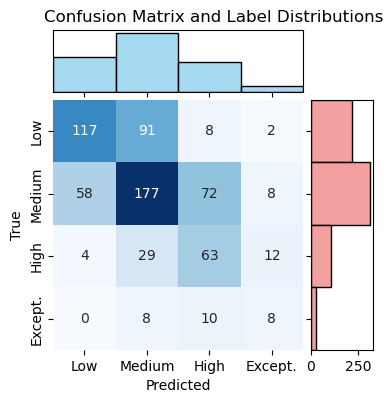

Recall per class: {'Low': np.float64(0.536697247706422), 'Medium': np.float64(0.5619047619047619), 'High': np.float64(0.5833333333333334), 'Except.': np.float64(0.3076923076923077)}


<Figure size 640x480 with 0 Axes>

In [558]:
# Assuming you have your true labels (y_test) and predicted labels (y_pred)
# Example data (replace with your actual data)
class_names = ['Low', 'Medium', 'High', 'Except.']  # Replace with your actual class names

# 2. Create a DataFrame for the Confusion Matrix (for better labeling)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# 3. Create the Joint Plot
fig = plt.figure(figsize=(4, 4))
gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Main plot: Confusion Matrix
ax_main = fig.add_subplot(gs[1, 0])
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax_main)
ax_main.set_xlabel('Predicted')
ax_main.set_ylabel('True')
# ax_main.set_title('Confusion Matrix')

# Top plot: Histogram of Predicted Labels
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
sns.histplot(np.array(y_pred)+0.5, discrete=True, ax=ax_top, color='skyblue')
ax_top.set_ylabel('')
# ax_top.set_yticklabels([])
# ax_top.set_xticks([])
ax_top.set_yticks([])
ax_top.tick_params(axis='x', labelbottom=False)

# Right plot: Histogram of True Labels
ax_right = fig.add_subplot(gs[1, 1], sharey=ax_main)
sns.histplot(y=np.array(y_test)+0.5, discrete=True, ax=ax_right, color='lightcoral', orientation='horizontal')
ax_right.set_xlabel('')
# ax_right.set_xticklabels([])
# ax_right.set_yticks([])
# ax_right.set_xticks([])
ax_right.tick_params(axis='y', labelleft=False)

plt.suptitle('Confusion Matrix and Label Distributions', y=0.95)
plt.show()

# To specifically highlight high recall:
# Calculate recall for each class
recall = np.diag(cm) / np.sum(cm, axis=1)
print("Recall per class:", dict(zip(class_names, recall)))

sns.despine(ax=ax_right)
sns.despine(ax=ax_top, top=True, right=True)
plt.tight_layout()

In [539]:
# classification report
# TODO where do you want to go? what are the requirements?
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.654     0.537     0.589       218
         1.0      0.580     0.562     0.571       315
         2.0      0.412     0.583     0.483       108
         3.0      0.267     0.308     0.286        26

    accuracy                          0.547       667
   macro avg      0.478     0.497     0.482       667
weighted avg      0.565     0.547     0.552       667



C:\Users\olive\AppData\Local\Temp\ipykernel_21556\809984286.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Low', 'Medium', 'High', 'Exceptionel'])


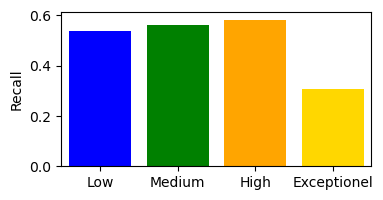

In [575]:
recall = recall_score(y_test, y_pred, labels=[0.,1.,2.,3.], average=None)

fig, ax = plt.subplots(1, 1, figsize=(4,2))
ax = sns.barplot(recall)
# ax.set_xticklabels({0:'Low', 1:'Medium', 2:'High', 3:'Exceptionel'})
ax.set_xticklabels(['Low', 'Medium', 'High', 'Exceptionel'])
ax.set_ylabel('Recall')

quality_label_colors = {
    'low'          :'blue',
    'medium'       :'green',
    'high'         :'orange',
    'exceptionel'  :'gold'
    }

for bars in ax.containers:
    for bar, color in zip(bars, quality_label_colors.values()):
        bar.set_facecolor(color)

In [540]:
# cohen kappa
cohen_kappa = cohen_kappa_score(y_test, y_pred)
cohen_kappa

np.float64(0.3113084981264188)

How to interpret Cohen Kappa:
- \>= 0.75: good
- 0.40 - 0.60: OK 
- < 0.40: fair, be sceptical
- 0: Random
- <0: worse than random 

## Feature Importances

Compare feature importances to correlations to quality: the ranking should be kind of similar, otherwise the model might rely on noisy data.

In [438]:
# # Access the components
# components = pipe[2].components_
# feature_names_in = pipe[1].get_feature_names_out()

# # Create a DataFrame to visualize the component loadings
# components_df = pd.DataFrame(components, columns=feature_names_in, index=[f'PC{i+1}' for i in range(pipe[2].n_components_)])
# components_df

In [439]:
# Volatile Acidity, Citric Acid, Chlorides, Sulphates, Total Sulfur Dioxide, Free Sulfur Dioxide, Residual Sugar

sulphates * alcohol                    0.039826
residual_sugar                         0.038833
free_sulfur_dioxide                    0.038515
chlorides * alcohol                    0.037778
ph * sulphates                         0.037140
citric_acid                            0.035652
fixed_acidity * free_sulfur_dioxide    0.035195
ph * fixed_acidity                     0.034987
ph * residual_sugar                    0.034872
fixed_acidity                          0.034711
ph                                     0.033397
volatile_acidity * density             0.033261
residual_sugar * density               0.033145
free_sulfur_dioxide * density          0.032252
sulphates                              0.031965
ph * alcohol                           0.031945
residual_sugar * alcohol               0.031731
total_sulfur_dioxide * alcohol         0.031630
density * alcohol                      0.030537
ph * density                           0.027976
dtype: float64


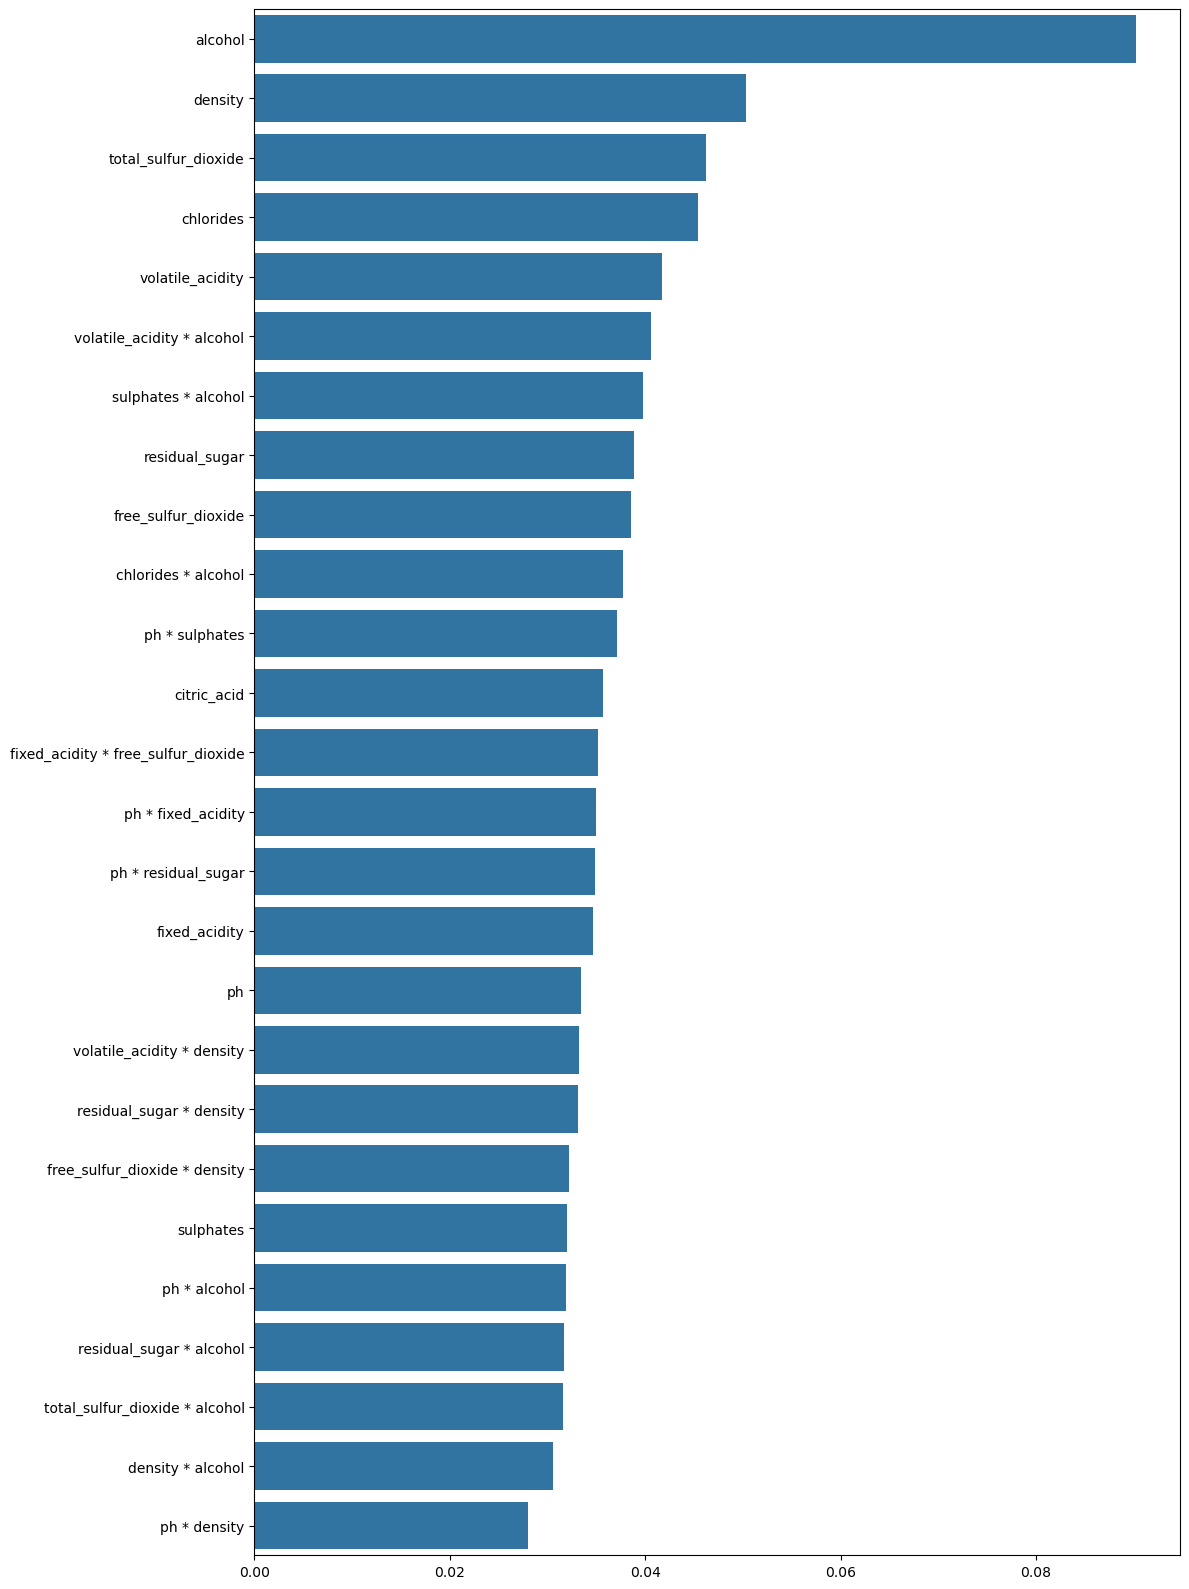

In [504]:
# feature importances
model = pipe.named_steps['classifier']
if hasattr(model, 'feature_importances_'):
    if len(model.feature_importances_) == len(X.columns):
        feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    else: 
        feature_names = [name.replace('remainder__','').replace(' ',' * ') for name in pipe[2].get_feature_names_out()]
        feature_importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
    print(feature_importances.tail(20))

    fig, ax = plt.subplots(1,1,figsize=(12,16))

    sns.barplot(feature_importances, orient='h', ax=ax)
    plt.tight_layout()

In [508]:
feature_importances_interactions = feature_importances[feature_importances.index.str.contains("\*")]
feature_importances_main = feature_importances[~feature_importances.index.str.contains("\*")]

n_interactions = len(feature_importances_interactions)
print('n_interactions', n_interactions)
print(feature_importances_interactions.tail(20).index)

n_interactions 15
Index(['volatile_acidity * alcohol', 'sulphates * alcohol',
       'chlorides * alcohol', 'ph * sulphates',
       'fixed_acidity * free_sulfur_dioxide', 'ph * fixed_acidity',
       'ph * residual_sugar', 'volatile_acidity * density',
       'residual_sugar * density', 'free_sulfur_dioxide * density',
       'ph * alcohol', 'residual_sugar * alcohol',
       'total_sulfur_dioxide * alcohol', 'density * alcohol', 'ph * density'],
      dtype='object')


<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
<>:1: SyntaxWarning: invalid escape sequence '\*'
<>:2: SyntaxWarning: invalid escape sequence '\*'
C:\Users\olive\AppData\Local\Temp\ipykernel_21556\2688485411.py:1: SyntaxWarning: invalid escape sequence '\*'
  feature_importances_interactions = feature_importances[feature_importances.index.str.contains("\*")]
C:\Users\olive\AppData\Local\Temp\ipykernel_21556\2688485411.py:2: SyntaxWarning: invalid escape sequence '\*'
  feature_importances_main = feature_importances[~feature_importances.index.str.contains("\*")]


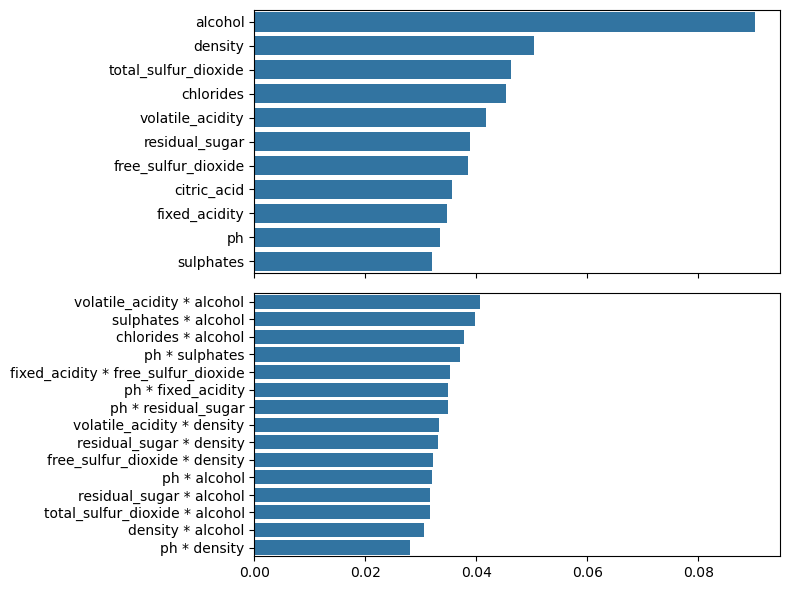

In [512]:
fig, ax = plt.subplots(2, 1, figsize=(8,6), sharex=True)
sns.barplot(feature_importances_main, orient='h', ax=ax[0])
sns.barplot(feature_importances_interactions, orient='h', ax=ax[1])
plt.tight_layout()

### Permutation Feature Importances

- Impact of individual feature permutations on predictions. 
- This method involves randomly shuffling a single feature's values and measuring the resulting performance decrease (e.g., accuracy, F1-score). 

                 Feature  Permutation Importance
10               alcohol                0.076312
2       volatile_acidity                0.052474
0                     ph                0.039130
9                density                0.035082
6    free_sulfur_dioxide                0.025637
8         residual_sugar                0.023238
4              chlorides                0.013943
5   total_sulfur_dioxide                0.011394
1          fixed_acidity                0.009595
7              sulphates                0.008996
3            citric_acid                0.000450


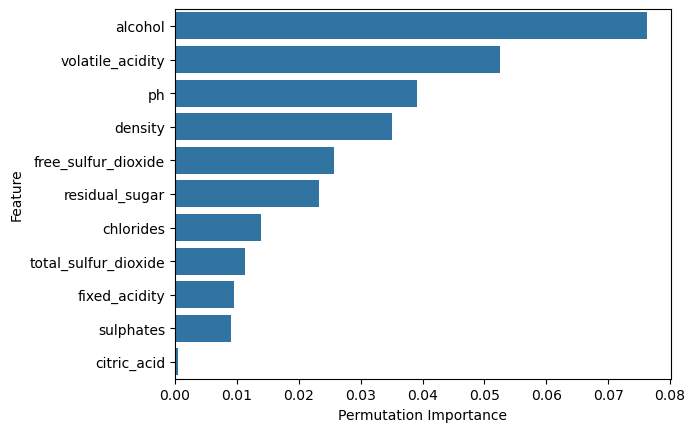

In [ ]:
# Permutation feature importance
result = permutation_importance(pipe, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)
perm_imp_df = pd.DataFrame({
    'Feature': features, 
    'Permutation Importance': result.importances_mean}).sort_values('Permutation Importance', ascending=False)

print(perm_imp_df)
sns.barplot(perm_imp_df, y='Feature', x='Permutation Importance', orient='h');

# TODO color bars
# for bars in a.containers:
#     for bar, color in zip(bars, colors):
#     bar.set_facecolor(color)

### Comments on Feature Importances
- As expected from oenologists alcohol is by far the most important feature. It is seen as the carrier for aroma and indicates a complete possibly good fermentation process.
- The following importances do not vary too much, i.e. each feature is almost equally important.
- The model heavily relies on the following features in order:
  - density, which is measure for sweetness and aroma.  
  - volatile acidity as a measure of aging 
  - ph the content of acids
  - total and free sulfur dioxide as a measure of age
  - residual sugar whcih determines the sweetness of wines
  - sulphates which are preservatives
  - chlorides for saltiness
  - fixed acidity
  - citric acid

The permutation on feature importances shows a different and more pronounced order of features than the built-in feature importances: 
- The model heavily relies on Alcohol, Volatile Acidity, Free Sulfur Dioxide;
- It strongly relies on Density, Chlorides, Total Sulfur Dioxide.
- Interestingly Fixed 
- Citric Acid are the least important as well.
- pH is even negative.

The result is closer to the correlation matrix result.

- Volatile Acidity and Free Sulfur Dioxide are more important than shown by the other methods.
Most surprisingly:
- 

### Comparison to Correlation Matrix 
- The model quite different from the correlation matrix.
  - Similarities: The dominant features are alcohol, density, 
  - Differences: 
    - It more strongly relies on Volatile Acidity and Free Sulfur Dioxide, less on Density to predict quality.
- Conclusions / Possibilities
  - Observation underlines non-linear, correlated nature of the problem.
  - Might hint to overfitting: The model pays more attention to the possibly noisy data: free sulfur dioxide and Volatile Acidity.

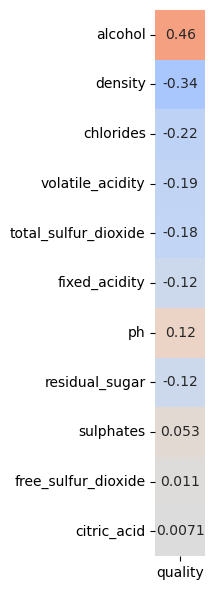

### SHAP Feature Importances

Currently not running! Too complicated for now.

In [370]:
# # # SHAP Explainer
# # TODO the thing does not work: evaluation of pipeline for some reason not possible; problem: undersampling, oversampling
# #   tried to separate the preprocessor from the pipeline and hand the transformed X,y to the explainer 
# # if  DO_SHAP_EXPLAINER:
# scaler = pipe[0]
# # X_train_transformed, y_train_transformed = preprocessor.fit_resample(X_train, y_train)
# X_test_transformed = scaler.transform(X_test)
# explainer = shap.Explainer(pipe[-1]) # Transform training data
# # explainer = shap.TreeExplainer(pipe[-1], X_test_transformed) # Transform training data
# shap_values = explainer(X_test) 

#     # pipeline_predict: is somehow very slow
#     # explainer = shap.Explainer(pipe.predict, X_train)
#     # shap_values = explainer(X_test)

#     # does not exist yet
#     # explainer = shap.PipelineExplainer(pipe, X_train)
#     # shap_values = explainer_pipeline(X_test)

#     # Waterfall plot for the first observation

# shap.plots.waterfall(shap_values[0, 0])

## Collinearity

In [393]:
# Calculate VIF for each feature
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print(vif_data.sort_values('VIF'))

                 Feature          VIF
8         residual_sugar     3.776187
4              chlorides     9.275162
6    free_sulfur_dioxide    11.413290
2       volatile_acidity    14.483400
3            citric_acid    16.801042
7              sulphates    25.604246
5   total_sulfur_dioxide    27.118595
1          fixed_acidity   107.460709
10               alcohol   135.040555
0                     ph   633.223506
9                density  1142.056044


The high VIF numbers indicate that features are strongly related:
- Density has by far the highest VIF, which is not surprising, since all quantities are somehow related to density.
- The same for pH and acids; and alcohol. 

## Condition number

In [394]:
from numpy.linalg import cond

# Calculate the condition number
condition_number = cond(X_train)
print(f"Condition Number: {condition_number}")

condition_number = cond(pipe[:-3].transform(X_train))
print(f"Condition Number: {condition_number}")

Condition Number: 9518.773463486099
Condition Number: 20.466346470634978


## Cross Validation

In [395]:
def print_cross_val_scores(scores):
    print("\nCross-validation scores:", scores)
    print("Mean accuracy:", np.mean(scores))
    print("Standard deviation of accuracy:", np.std(scores))
    return None

In [ ]:
# Stratified k fold
DO_CROSS_VAL=True
if DO_CROSS_VAL:
    sk_folds = StratifiedKFold(n_splits = 5)#, shuffle=False, random_state=RANDOM_STATE)
    f1_weighted = cross_val_score(pipe, X, y, cv=sk_folds, scoring='f1_weighted', n_jobs=-1)
    accuracy = cross_val_score(pipe, X, y, cv=sk_folds, scoring='accuracy', n_jobs=-1)
    print_cross_val_scores(f1_weighted)
    print_cross_val_scores(accuracy)


Cross-validation scores: [0.48875562 0.50900901 0.54054054 0.5015015  0.51051051]
Mean accuracy: 0.5100634367500934
Standard deviation of accuracy: 0.017073343227599916

Cross-validation scores: [0.48875562 0.50900901 0.54054054 0.5015015  0.51051051]
Mean accuracy: 0.5100634367500934
Standard deviation of accuracy: 0.017073343227599916


In [376]:
# Repeated Random Test-Train Splits
if DO_CROSS_VAL:
    kfold2 = ShuffleSplit(n_splits=10, test_size=0.30, random_state=100)
    scores = cross_val_score(pipe, X, y, cv=kfold2)
    print_cross_val_scores(scores)


Cross-validation scores: [0.556 0.519 0.504 0.528 0.553 0.531 0.487 0.559 0.562 0.557]
Mean accuracy: 0.5356000000000001
Standard deviation of accuracy: 0.02477175811281874


* The accuracy from cross validation is lower than the above calculated accuracy. Reasons could be: 
  * class imbalance 
  * overfitting
* The standard deviation is low, indicating that the model is well fitted and might not be overfitted.

# Notes

## Open Questions / Tasks
- Which model to use? Other models that might be useful:
  - random forest
  - gradient boosting tree
  - neural network
- How to tune the model? Hyperparameter Tuning later on
- EDA: What's the connection? Can another feature be thrown out in order to improve the ML result?

## Requirements

### What does the user want?
* A process to simply determine if the produced wine might be high quality or not.
* A simple process could look like this:
  * Measure the basic properties (they might have to measured anyways)
    * residual sugar, ph, density, total sulfur dioxide, fixed and volatile acidity, alcohol
  * If possible, measure the more advanced features: citric acid, chlorides, free sulfur dioxides, sulphates
  * Use the model to infer possible quality rating.
  * Compare the result with the taste of the wine to omit false negative, possibly invite a taster.
  * If good then set the price and marketing strategy appropriately 

### How to setup the model?

1. As many high quality wines predicted correctly, because the quality shall be determined as accurate as possible
   1. accuracy: the model should be as accurate as possible
   2. recall: wine that is actually high quality should be predicted as high quality
   3. high f1-score: 
   4. precision: 
2. Reduce low quality wine creep, i.e. low quality wine predicted as high quality wine.
   1. high f1-score for low quality: 
3. Accuracy as high as possible.

## Results

* Tune Target **Quality Label**
  * With the original quality label definition no high quality wine could be predicted correctly.
  * The high quality wine group is too small!
  * Oversampling and Undersampling further improves the model, see below.
  * Test with more quality levels, in order to emphasize the high quality features:
    * Good result according to confusion matrix, although accuracy is significantly lower.
    * Pros: Exceptional wines can be classified ok manner.
    * Cons: Low precision on exceptional wines.
    * Conlcusion: 
      * not enough high quality data to predict high quality wines
      * stick to 3 labels for now
    * Stack another model on top to differentiate between high and exceptional?
* **Model selection**: compare SVC and RandomForest
  * overall RandomForest yields better results
  * however SVC is great on recall for high quality
  * can the algorithms be combined? yes! stacking
* Which is the appropriate **scaling method**?
  * Compare RobustScaler and MinMaxScaler
  * Result: RobustScaler is slightly better for determining high quality wines
  * What is the influence of the outliers? Removing Outliers before and after
* **Dealing with outliers**
  * Remove all outliers
    * better confusion matrix: Less bad wine is predicted as higher quality; medium wine is more balanced. 
    * lower accuracy score, but better precision, recall, precision. 
  * Remove low quality outliers: Improvement for all scores
    * best result with quality <= 6
    * skew and kurtosis can be reduced with outlier removal.
  * Remove low quality outliers and outliers determined by IsolationForest:
    * best result with quality <= 7: this seems a bit random!
    * improvement of the result!
  * What happens if the high quality outliers are only used for training or testing? 
* **Oversampling and Undersampling**
  * smearing of the confusion matrix
  * leads to slighty lower accuracy, but higher f1 scores for low and high quality
  * major improvement for high quality!
  * With and without outliers? 
  * What about scaling?
* **Feature selection**
  * What is the influence of the other steps on this topic? 
  * **Overall result**: Until now, the best results were achieved when all original features are kept.
    * It seems that all features play a kind of crucial role in this classification problem!
    * Why is this? Although the correlation matrix indicates that collinearity effects might be present, it seems that non-linear effects are more important. This underlines the non-linear, interdependent nature of this problem and calls for machine learning models.
  * Remove features with the lowest impact on quality (citric acid, sulphates, free sulfur dioxide): makes it worse!
  * Remove features which are strongly correlated to each other in order to omit collinearity effects:
    * alcohol, density, residual sugar are strongly correlated
    * remove residual sugar: no improvement
    * remove ph, because it's kind of similar to the acids, it may represent acids that are not yet included; it could simplify model interpretation: no improvement, only a slight difference 
    * remove acids: no improvement
    * remove small values with little spread depending on histogram because the introduce noise, which are sulphates: no improvement 
  * Remove features with high VIF scores: no improvement
  * Remove features by applying PCA: Did not yield a better result, because it's a non-linear problem!
  * Summarize features and replace others
    * sulfur dioxide ratio of free sulfur dioxide or both sulfur dioxide quantities: did not improve the result
    * acid ratio instead: looked promising, but no improvement
    * total acid instead of acids: no improvement; the quantity is mainly driven by Fixed Acid and the features of the other acids are lost 
    * residual sugar * density * alcohol: did not make sense until; proper normalization is necessary
* Use **Quality instead of Quality Label**
  * similar results to modified quality label
  * low quality wines are predicted to be higher quality; high quality wines tend to be rated with lower quality. 
    * Cut off very low quality wines? 
    * What to do about imbalance in data set?
      * Oversamplig does not work here (before it has not really changed the confusion matrix).
      * Use cross validation to check for overfitting effects
* **Cross validation**
  * What is the result of cross validation? What is used for? What does validation exactly mean? Cross validation yields an interesting result: normally the model performs better in cross validation, however, in this case this is not the case.
* **Feature interactions**
  * Included Feature Interaction Terms in order to get rid of the the noisy stuff (volatile acidity, chlorides) and investigate model complexity.
  * Trimming
    * with PCA: no improvement
    * backward elimination: remove the least important interactions
  * With the previously optimzed parameters: no improvement, which shows that I might be caught in overfitting already
  * Did I overcome Overfitting and create real features?
    * grid search hints to this: reasonable parameters, no slipping away
  * What is 
* **Log-Scaling of features**
  * also did not change anything
  * actually i should repeat the gridsearch!

# Presentation

1. Introduction slide
2. Agenda
3. EDA
4. Machine Learning
   2. Configuration and Tuning: What was done and why? The road to the model
      1. Model: RandomForestClassifier vs SVM (vs ???)
      2. Scaling: RobustScaler vs MinMaxScaler
      3. Imbalanced data: Undersampling, Oversampling
      4. Cross validation: What does the std tell us about the model?
   3. What about the outliers?
      1. I removed the low quality outliers.
      2. Improvement of the model: Accuracy decreased slightly, 
   4. What was achieved? Is the model a good classification machine for the winery?
      1. Resulting confusion matrix
   5. Is the model a good classification machine for the winery?
      1. Up to now high quality wine can be predicted pretty well.
      2. Is more data needed? 